<a href="https://colab.research.google.com/github/jeffjaylacs/stable-diffusion-2-0/blob/main/sd_2_0_text_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion 2.0 Textual Inversion inference

by Max Woolf (@minimaxir)

A personal notebook for easy inference with Stable Diffusion 2.0 using diffusers, including textual inversion support (the `<wrong>` token is loaded by default), grid output, and individual image output.

You will need a login at [Hugging Face](https://huggingface.co) in order to download Stable Diffusion.

In [9]:
!nvidia-smi

Wed Dec  7 19:59:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
!pip install -qq diffusers["torch"] transformers
!pip install -qq "ipywidgets>=7,<8"

In [11]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
from PIL import Image
import os
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import notebook_login, hf_hub_url
import requests

model_id = "stabilityai/stable-diffusion-2-base"

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

The following cell downloads the `<wrong>` token to be used in a negative prompt:

In [12]:
token_url=hf_hub_url(repo_id="minimaxir/wrong_embedding_sd_2_0",
                     filename="learned_embeds.bin")
r = requests.get(token_url, allow_redirects=True)
open('wrong.bin', 'wb').write(r.content)

4843

In [13]:
notebook_login()

In [14]:
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
    use_auth_token=True,
)
text_encoder = CLIPTextModel.from_pretrained(
    model_id, subfolder="text_encoder", use_auth_token=True
)

vocab_size = tokenizer.vocab_size

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/738 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

In [15]:
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  
  # separate token and the embeds
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]

  # cast to dtype of text_encoder
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  # add the token in tokenizer
  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
  # resize the token embeddings
  text_encoder.resize_token_embeddings(len(tokenizer))
  
  # get the id for the token and assign the embeds
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds

  print(trained_token)


Input any other diffusers-trained textual inversion tokens here:

In [16]:
embed_paths = [
    "wrong.bin",
    ]

for embed in embed_paths:
    load_learned_embed_in_clip(embed, text_encoder, tokenizer)

<wrong>


In [17]:
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               scheduler=scheduler,
                                               text_encoder=text_encoder,
                                               tokenizer=tokenizer,
                                               revision="fp16",
                                               torch_dtype=torch.float16,
                                               safety_checker=None)
pipe = pipe.to("cuda")

Downloading:   0%|          | 0.00/308 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/340 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/820 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

The main cell for running inference for Stable Diffusion.

The final generated grid image will be saved as `grid.png` in the sidebar. Individual full-resolution image outputs will be saved into the `outputs` folder (in an individual subfolder for each prompt to avoid overwriting) for further download.

  0%|          | 0/50 [00:00<?, ?it/s]

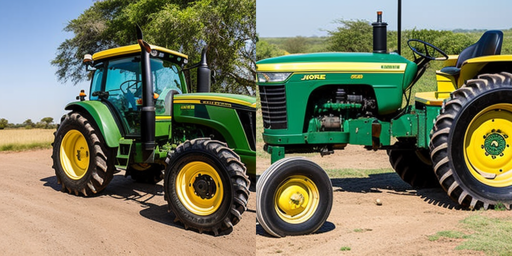

  0%|          | 0/50 [00:00<?, ?it/s]

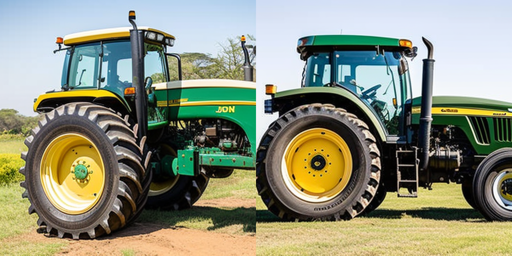

In [30]:
prompt = "John Deere tractor on African safari, photograph, hyper-detailed and intricate, fine detail, sharp focus, 8K resolution"
negative_prompt =  None
negative_prompt = "in the style of <wrong>"  # comment this line out to use no negative prompt

num_inference_steps = 50
guidance_scale = 7.5

num_samples = 2  # may have to set to 2 OOM; if 16GB GPU, can go to 4.
num_rows = 2

all_images = [] 
for _ in range(num_rows):
    with torch.autocast("cuda"):
        images = pipe(prompt,
                      negative_prompt=negative_prompt,
                      num_images_per_prompt=num_samples,
                      num_inference_steps=num_inference_steps,
                      guidance_scale=guidance_scale)["images"]
        all_images.extend(images)
        image_large = image_grid(images, 1, num_samples)
        display(image_large.resize((image_large.width // 2, image_large.height // 2)))
        
grid = image_grid(all_images, num_samples, num_rows)
grid.save("grid.png")

#if not os.path.exists("outputs"):
#    os.mkdir("outputs")

#prompt_folder = prompt.replace("/", "_")[0:128]

#if not os.path.exists(os.path.join("outputs", prompt_folder)):
#    os.mkdir(os.path.join("outputs", prompt_folder))

#for i, image in enumerate(all_images):
#    image.save(os.path.join("outputs", prompt_folder, f"{i+1:02d}.png"))

---

MIT License

Copyright (c) 2022 Max Woolf

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
